Robust MPC: Simulation with linearized rocket system

In [34]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
# Add current directory to sys.path to allow importing LandMPC_6_1
#sys.path.append(os.getcwd())

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from LandMPC_6_1.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *
import numpy as np

# Require ipympl
%matplotlib widget 

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

# Part 6.1: Robust MPC for landing from z=10 to z=3
# Goal: Settling time ≤ 4 seconds for no_noise case
sim_time = 5.0  # simulation length in seconds

# Initial state: z = 10 m, vz = 0 m/s (full 12-state vector)
x0 = np.array([0, 0, 0, 0, 0, np.deg2rad(30), 0, 0, 0, 3, 2, 10]) #ATTENTION FAUT METTRE EN RAD!!
# x0[11] = 10.0  # z = 10 m (initial height)
# x0[8] = 0.0  # vz = 0 m/s (default)

# Initial state: Starting from z = 10 m, zero vertical velocity
# States for sys_z: [vz, z] (indices [8, 11] in full state vector)
x_ref = np.array([0.]*9 + [1., 0., 3.])
# x_ref = np.zeros(12)
# x_ref[11] = 3.0  # z = 3 m (target landing height)

# Trim the rocket around the reference state
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

# Linearize the z-subsystem
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B

# Horizon for MPC (as per design procedure)
H = 5.0  # Prediction horizon in seconds

# Initialize MPC controller for z-subsystem
mpc = MPCControl_z(A, B, xs, us, Ts, H)


print("\nMPC Controller initialized with:")
print(f"  Q = diag([500.0, 5000.0]) for [vz, z] (tuned for ~4s settling in no_noise, same for all cases)")
print(f"  R = [0.1] for [Pavg] (same for all cases)")
print(f"  Input constraints: 55 ≤ Pavg ≤ 75 (tightened from [40, 80])")
print(f"  State constraints: z ≥ 1.0 m (time-varying: 0.0/0.5/1.0 m)")
print(f"  Prediction horizon: H = {H} seconds")

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]

MPC Controller initialized with:
  Q = diag([500.0, 5000.0]) for [vz, z] (tuned for ~4s settling in no_noise, same for all cases)
  R = [0.1] for [Pavg] (same for all cases)
  Input constraints: 55 ≤ Pavg ≤ 75 (tightened from [40, 80])
  State constraints: z ≥ 1.0 m (time-varying: 0.0/0.5/1.0 m)
  Prediction horizon: H = 5.0 seconds


Testing with random disturbances (w ∈ [-15, 5] uniformly distributed)...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

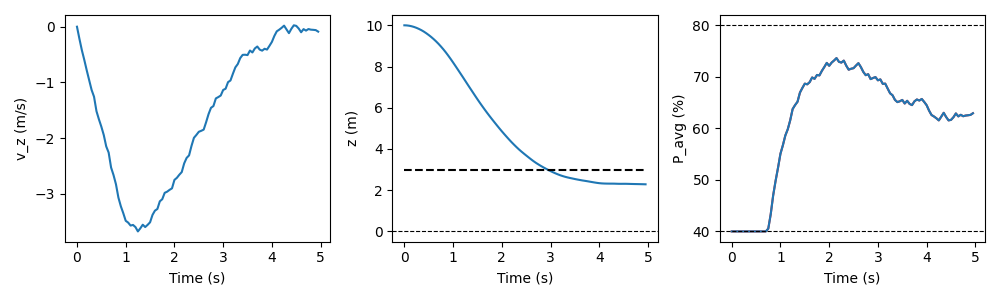

In [36]:
# Test with random disturbances
print("Testing with random disturbances (w ∈ [-15, 5] uniformly distributed)...")
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

Testing with extreme disturbances (w = -15 constant, worst case)...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

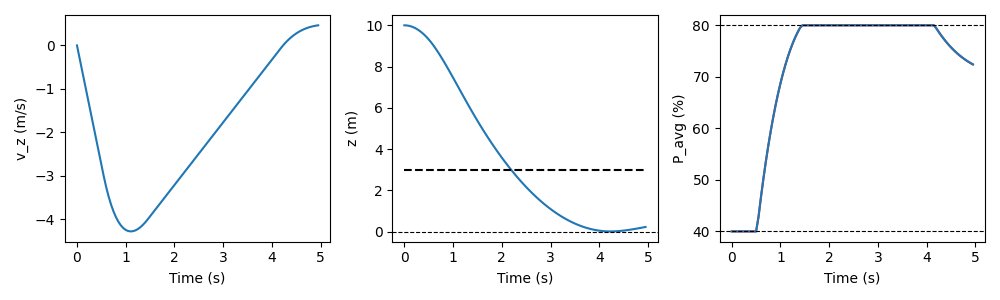

In [37]:
# Test with extreme disturbances (w = -15 constant, worst case)
print("Testing with extreme disturbances (w = -15 constant, worst case)...")
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')


Testing with no noise (nominal case) to verify settling time ≤ 4 seconds...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

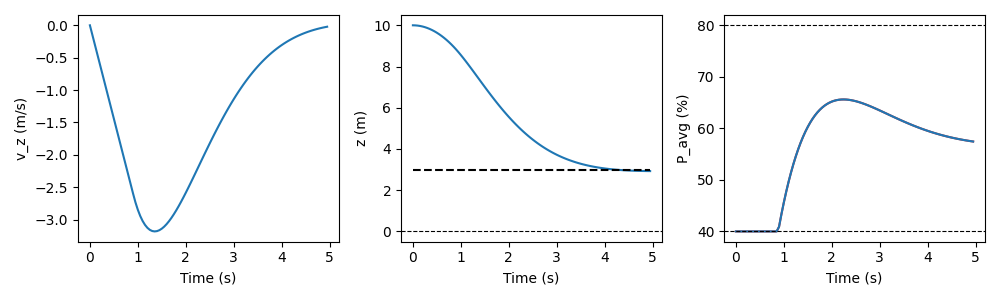

In [38]:
# Test with no noise (nominal case) to verify settling time ≤ 4 seconds
print("Testing with no noise (nominal case) to verify settling time ≤ 4 seconds...")
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='no_noise')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')



In [39]:
from mpt4py import Polyhedron
import matplotlib.pyplot as plt

# Get system matrices (in delta coordinates - centered around origin)
A_d = np.array(mpc.A, dtype=float)   # discrete A for sys_z (2x2)
B_d = np.array(mpc.B, dtype=float)   # discrete B for sys_z (2x1)
K   = np.array(mpc.K, dtype=float)   # tube gain (1x2)

# Closed-loop matrix
A_cl = A_d + B_d @ K

# Get steady-state values for delta coordinate transformation
xs = mpc.xs  # [vz_steady, z_steady]
us = mpc.us  # [Pavg_steady]

print("System setup:")
print(f"A_cl eigenvalues: {np.linalg.eigvals(A_cl)}")
print(f"A_cl eigenvalue magnitudes: {np.abs(np.linalg.eigvals(A_cl))}")
print(f"B_d: {B_d.flatten()}")
print(f"K: {K.flatten()}")
print(f"Steady-state: xs = {xs}, us = {us}")

# Define constraints in delta coordinates (centered around origin)
# State constraints in delta coordinates
# State is [vz_delta, z_delta] where z_delta = z - z_steady
# Absolute constraint: z >= 0, so z_delta >= -z_steady
z_steady = xs[1]  # z at trim point
z_delta_min = -z_steady  # Minimum z_delta to satisfy z >= 0
z_delta_max = 12.0 - z_steady  # Allow up to z=12 in absolute coordinates
vz_delta_max = 10.0  # Symmetric bound for velocity

# Define X as a box containing origin: -vz_max <= vz_delta <= vz_max, z_delta_min <= z_delta <= z_delta_max
X_A = np.vstack((np.eye(2), -np.eye(2)))
X_b = np.array([vz_delta_max, z_delta_max, vz_delta_max, -z_delta_min])
X = Polyhedron.from_Hrep(X_A, X_b)

# Input constraints in delta coordinates
# Absolute constraint: 40 <= u <= 80, so u_delta = u - us[0] where us[0] is Pavg_steady
Pavg_steady = us[0]  # Steady-state Pavg
u_delta_min = 40.0 - Pavg_steady  # Minimum u_delta to satisfy u >= 40
u_delta_max = 80.0 - Pavg_steady  # Maximum u_delta to satisfy u <= 80

# Define U as a box containing origin (may not be symmetric, but must contain 0)
U_A = np.vstack((np.eye(1), -np.eye(1)))
U_b = np.array([u_delta_max, -u_delta_min])
U = Polyhedron.from_Hrep(U_A, U_b)

# Disturbance set: w ∈ [-15, 5] (scalar) - defined as 1D set first
w_min, w_max = -15.0, 5.0
W_A = np.vstack((np.eye(1), -np.eye(1)))
W_b = np.array([w_max, -w_min])  # Note: w_max = 5, -w_min = 15
W = Polyhedron.from_Hrep(W_A, W_b)

# Map disturbance through input matrix: B @ W gives 2D disturbance set in state space
B_W = W.affine_map(B_d)

print(f"Disturbance w ∈ [{w_min}, {w_max}]")
print(f"Disturbance set W (1D): {W}")
print(f"Disturbance set B_W in state space (2D): {B_W}")

# Define function for minimal robust invariant set (following exercise 7 style)
def min_robust_invariant_set(A_cl: np.ndarray, W: Polyhedron, max_iter: int = 50) -> Polyhedron:
    """Compute minimal robust invariant set E (following exercise 7 style)."""
    nx = A_cl.shape[0]
    Omega = W
    itr = 0
    while itr < max_iter:
        A_cl_ith_power = np.linalg.matrix_power(A_cl, itr)
        print(f'  Iteration {itr+1}: computing A_cl^{itr} @ W...', end=' ')
        Omega_next = Omega + A_cl_ith_power @ W
        Omega_next.minHrep()  # optionally: Omega_next.minVrep()
        print('done')
        
        if np.linalg.norm(A_cl_ith_power, ord=2) < 1e-2:
            print('Minimal robust invariant set computation converged after {0} iterations.'.format(itr))
            break

        if itr == max_iter - 1:
            print('Minimal robust invariant set computation did NOT converge after {0} iterations.'.format(max_iter))
        
        Omega = Omega_next
        itr += 1
    return Omega_next

# Define function for maximum invariant set (following exercise 7 style)
def max_invariant_set(A_cl: np.ndarray, X: Polyhedron, max_iter: int = 50) -> Polyhedron:
    """
    Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
    (following exercise 7 style)
    """
    O = X
    itr = 1
    converged = False
    while itr < max_iter:
        Oprev = O
        F, f = O.A, O.b
        # Compute the pre-set
        O = Polyhedron.from_Hrep(np.vstack((F, F @ A_cl)), np.vstack((f, f)).reshape((-1,)))
        O.minHrep()
        if O == Oprev:
            converged = True
            break
        print('Iteration {0}... not yet converged'.format(itr))
        itr += 1
    
    if converged:
        print('Maximum invariant set successfully computed after {0} iterations.\n'.format(itr))
    else:
        print('Maximum invariant set computation did NOT converge after {0} iterations.'.format(max_iter))
    return O


System setup:
A_cl eigenvalues: [0.95301592+0.03189564j 0.95301592-0.03189564j]
A_cl eigenvalue magnitudes: [0.95354951 0.95354951]
B_d: [0.00865235 0.00021631]
K: [-10.67406137  -7.45423943]
Steady-state: xs = [0. 3.], us = [56.66666667]
Disturbance w ∈ [-15.0, 5.0]
Disturbance set W (1D): <mpt4py.geometry.polyhedron.Polyhedron object at 0x30baed430>
Disturbance set B_W in state space (2D): <mpt4py.geometry.polyhedron.Polyhedron object at 0x3179f7380>


In [40]:
# Compute minimal robust invariant set E (using B_W, the 2D disturbance set)
print("Computing minimal robust invariant set E...")
E = min_robust_invariant_set(A_cl, B_W)
print(f"\nMinimal robust invariant set E computed.")
try:
    print(f"E vertices:\n{E.Vrep}")
except:
    print("E H-representation:")
    print(f"A: {E.A}")
    print(f"b: {E.b}")


Computing minimal robust invariant set E...
  Iteration 1: computing A_cl^0 @ W... done
  Iteration 2: computing A_cl^1 @ W... done
  Iteration 3: computing A_cl^2 @ W... done
  Iteration 4: computing A_cl^3 @ W... done
  Iteration 5: computing A_cl^4 @ W... done
  Iteration 6: computing A_cl^5 @ W... done
  Iteration 7: computing A_cl^6 @ W... done
  Iteration 8: computing A_cl^7 @ W... done
  Iteration 9: computing A_cl^8 @ W... done
  Iteration 10: computing A_cl^9 @ W... done
  Iteration 11: computing A_cl^10 @ W... done
  Iteration 12: computing A_cl^11 @ W... done
  Iteration 13: computing A_cl^12 @ W... done
  Iteration 14: computing A_cl^13 @ W... done
  Iteration 15: computing A_cl^14 @ W... done
  Iteration 16: computing A_cl^15 @ W... done
  Iteration 17: computing A_cl^16 @ W... done
  Iteration 18: computing A_cl^17 @ W... done
  Iteration 19: computing A_cl^18 @ W... done
  Iteration 20: computing A_cl^19 @ W... done
  Iteration 21: computing A_cl^20 @ W... done
  Iterati

In [41]:
# Compute tightened state constraints: X_tilde = X ⊖ E
print("Computing tightened state constraints X_tilde = X ⊖ E...")
X_tilde = X - E
print("Tightened state constraints X_tilde computed.")


Computing tightened state constraints X_tilde = X ⊖ E...
Tightened state constraints X_tilde computed.


In [42]:
# Compute tightened input constraints: U_tilde = U ⊖ K*E
print("Computing tightened input constraints U_tilde = U ⊖ K*E...")
KE = E.affine_map(K)  # K @ E = {K*e : e ∈ E}
U_tilde = U - KE
print("Tightened input constraints U_tilde computed.")
try:
    print(f"U_tilde vertices:\n{U_tilde.Vrep}")
except:
    print("U_tilde H-representation:")
    print(f"A: {U_tilde.A}")
    print(f"b: {U_tilde.b}")


Computing tightened input constraints U_tilde = U ⊖ K*E...
Tightened input constraints U_tilde computed.
U_tilde vertices:
VData(V=array([[ 3.97988363],
       [-9.70597943]]), R=array([], shape=(0, 1), dtype=float64), is_minimal=False)


In [43]:
# Terminal set for nominal MPC: Xf = max_invariant(X ∩ {x : K*x ∈ U})
print("Computing terminal set Xf for nominal MPC...")
X_and_KU = X.intersect(Polyhedron.from_Hrep(U.A @ K, U.b))
Xf = max_invariant_set(A_cl, X_and_KU)
print(f"Terminal set Xf for nominal MPC computed.")
try:
    print(f"Xf vertices:\n{Xf.Vrep}")
except:
    print("Xf H-representation:")
    print(f"A: {Xf.A}")
    print(f"b: {Xf.b}")


Computing terminal set Xf for nominal MPC...
Iteration 1... not yet converged
Iteration 2... not yet converged
Iteration 3... not yet converged
Iteration 4... not yet converged
Iteration 5... not yet converged
Iteration 6... not yet converged
Iteration 7... not yet converged
Iteration 8... not yet converged
Iteration 9... not yet converged
Iteration 10... not yet converged
Iteration 11... not yet converged
Maximum invariant set successfully computed after 12 iterations.

Terminal set Xf for nominal MPC computed.
Xf vertices:
VData(V=array([[-6.08397357,  5.59280796],
       [-6.48095706,  6.22111346],
       [-6.86468221,  6.8885032 ],
       [-7.22666002,  7.59323552],
       [-7.55694616,  8.33264803],
       [-7.80760001,  9.        ],
       [ 3.65646998, -3.        ],
       [-4.72373977,  9.        ],
       [-7.70666087,  8.7142382 ],
       [-7.39644714,  7.9588132 ],
       [-7.04897515,  7.23634464],
       [-6.67497516,  6.55001177],
       [-6.28364479,  5.90199842],
      

In [44]:
# Terminal set for tube MPC: Xf_tilde = max_invariant(X_tilde ∩ {x : K*x ∈ U_tilde})
print("Computing terminal set Xf_tilde for tube MPC...")
X_tilde_and_KU_tilde = X_tilde.intersect(Polyhedron.from_Hrep(U_tilde.A @ K, U_tilde.b))
Xf_tilde = max_invariant_set(A_cl, X_tilde_and_KU_tilde)
print(f"Terminal set Xf_tilde for tube MPC computed.")
try:
    print(f"Xf_tilde vertices:\n{Xf_tilde.Vrep}")
except:
    print("Xf_tilde H-representation:")
    print(f"A: {Xf_tilde.A}")
    print(f"b: {Xf_tilde.b}")


Computing terminal set Xf_tilde for tube MPC...
Iteration 1... not yet converged
Iteration 2... not yet converged
Iteration 3... not yet converged
Iteration 4... not yet converged
Iteration 5... not yet converged
Iteration 6... not yet converged
Iteration 7... not yet converged
Iteration 8... not yet converged
Iteration 9... not yet converged
Iteration 10... not yet converged
Iteration 11... not yet converged
Iteration 12... not yet converged
Iteration 13... not yet converged
Iteration 14... not yet converged
Iteration 15... not yet converged
Iteration 16... not yet converged
Iteration 17... not yet converged
Iteration 18... not yet converged
Iteration 19... not yet converged
Iteration 20... not yet converged
Iteration 21... not yet converged
Iteration 22... not yet converged
Iteration 23... not yet converged
Iteration 24... not yet converged
Iteration 25... not yet converged
Iteration 26... not yet converged
Iteration 27... not yet converged
Iteration 28... not yet converged
Iteration

In [45]:
# Print vertices of U_tilde
print("\n" + "="*60)
print("Vertices of tightened input constraint Ũ:")
print("="*60)
try:
    print(U_tilde.Vrep)
except:
    print("Could not extract vertices. U_tilde H-representation:")
    print(f"A: {U_tilde.A}")
    print(f"b: {U_tilde.b}")



Vertices of tightened input constraint Ũ:
VData(V=array([[ 3.97988363],
       [-9.70597943]]), R=array([], shape=(0, 1), dtype=float64), is_minimal=False)


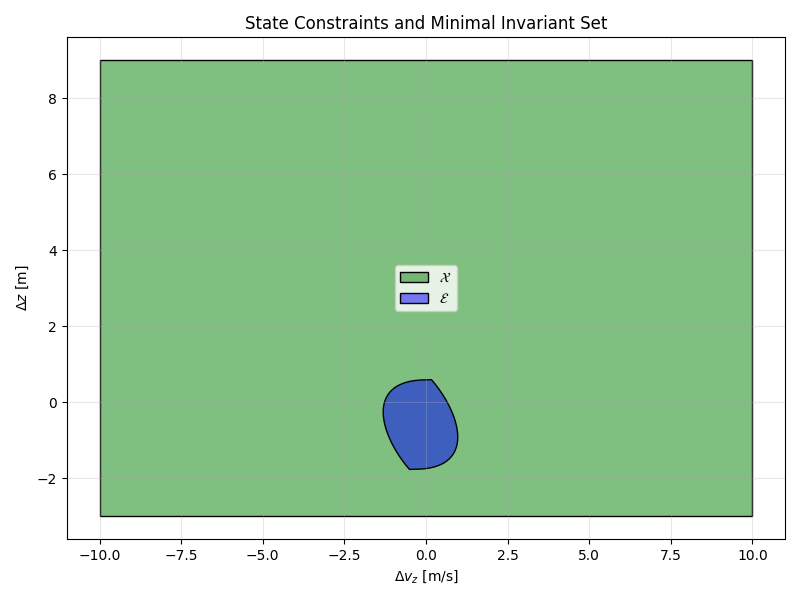

In [46]:
# Plot 1: X and E
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
X.plot(ax, color='green', opacity=0.5, label=r'$\mathcal{X}$')
E.plot(ax, color='blue', opacity=0.5, label=r'$\mathcal{E}$')
ax.set_xlabel(r'$\Delta v_z$ [m/s]')
ax.set_ylabel(r'$\Delta z$ [m]')
ax.set_title('State Constraints and Minimal Invariant Set')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('auto')
plt.tight_layout()
plt.show()


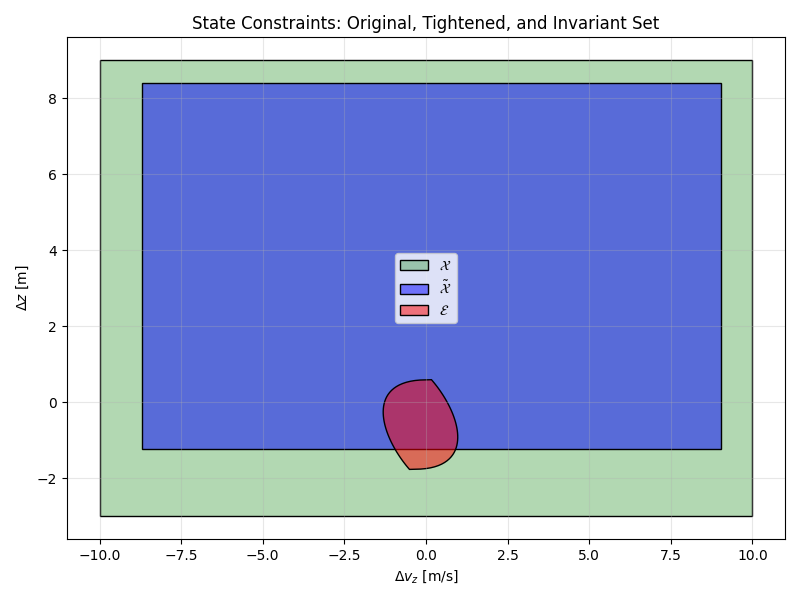

In [47]:
# Plot 2: X, X_tilde and E
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
X.plot(ax, color='green', opacity=0.3, label=r'$\mathcal{X}$')
X_tilde.plot(ax, color='blue', opacity=0.5, label=r'$\tilde{\mathcal{X}}$')
E.plot(ax, color='red', opacity=0.5, label=r'$\mathcal{E}$')
ax.set_xlabel(r'$\Delta v_z$ [m/s]')
ax.set_ylabel(r'$\Delta z$ [m]')
ax.set_title('State Constraints: Original, Tightened, and Invariant Set')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('auto')
plt.tight_layout()
plt.show()


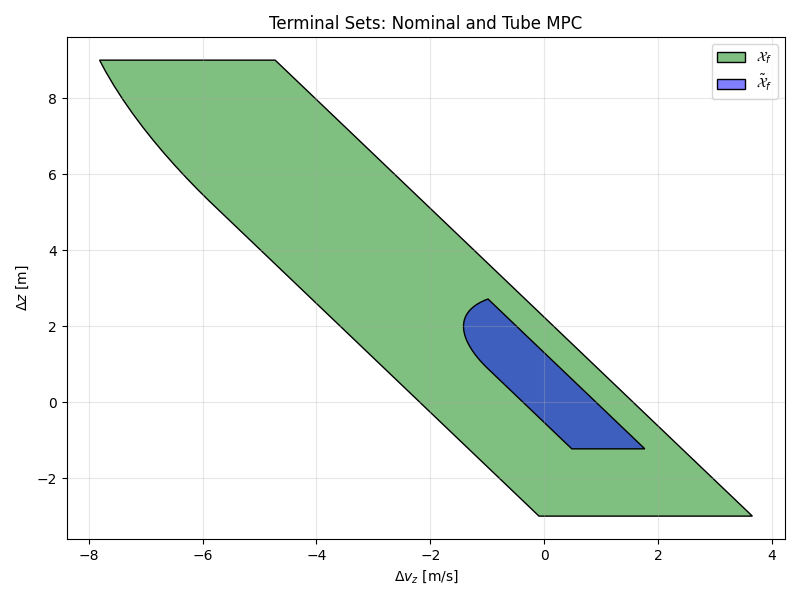

In [48]:
# Plot 3: Xf and Xf_tilde
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
Xf.plot(ax, color='green', opacity=0.5, label=r'$\mathcal{X}_f$')
Xf_tilde.plot(ax, color='blue', opacity=0.5, label=r'$\tilde{\mathcal{X}}_f$')
ax.set_xlabel(r'$\Delta v_z$ [m/s]')
ax.set_ylabel(r'$\Delta z$ [m]')
ax.set_title('Terminal Sets: Nominal and Tube MPC')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('auto')
plt.tight_layout()
plt.show()
